Setup Enviroment and Variables

In [101]:
!nvidia-smi -L

!nvcc --version

GPU 0: Tesla K80 (UUID: GPU-386b3ce1-2cf4-4947-5f15-b65fbbf0d10a)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [102]:
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

!pip3 install opensimplex click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git 

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


In [103]:
import sys
sys.path.insert(0, '/content/stylegan2-ada-pytorch')
emotions_dict = {
    "amusement": 0,
    "anger": 1,
    "awe": 2,
    "contentmennt": 3,
    "disgust": 4,
    "excitement": 5,
    "fear": 6,
    "sadness": 7
}
import os
import re
from typing import List, Optional, Any
import click
import numpy as np
import PIL.Image
import torch
import pickle

!rm -rf sample_data/
!gdown --id '1N_6fsmF2FfWyCowvMFSsWnfOnRMxnwb4'
'''!gdown --id '1GvgdIldjMGV48JE5TGWjtdpGykTsuJ_L'
!unzip '/content/utils.zip'
!rm -rf __MACOSX/
!rm -rf utils.zip
'''
import dnnlib
import legacy
emostylegan_model = '/content/network-snapshot-025000.pkl'
outdir = '/content/image_generation'
seed = 10

Downloading...
From: https://drive.google.com/uc?id=1N_6fsmF2FfWyCowvMFSsWnfOnRMxnwb4
To: /content/network-snapshot-025000.pkl
295MB [00:01, 165MB/s]


Functions to be used to generate image

In [104]:
def num_range(s: str) -> List[int]:
    '''Accept either a comma separated list of numbers 'a,b,c' or a range 'a-c' and return as a list of ints.'''

    range_re = re.compile(r'^(\d+)-(\d+)$')
    m = range_re.match(s)
    if m:
        return list(range(int(m.group(1)), int(m.group(2))+1))
    vals = s.split(',')
    return [int(x) for x in vals]


In [105]:
def generate_images(
    network_pkl: str,
    seeds: Optional[List[int]],
    truncation_psi: float,
    outdir: str,
    class_idx: Optional[int],
    emotion: str,
):
  
  print('Loading networks from "%s"...' % network_pkl)
  device = torch.device('cuda')
  with dnnlib.util.open_url(network_pkl) as f:
      G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

  os.makedirs(outdir, exist_ok=True)
   # Labels.
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
        print ('warn: --class=lbl ignored when running on an unconditional network')

  # Generate images.
  for seed_idx, seed in enumerate(seeds):
      print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
      z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
      img = G(z, label, truncation_psi=truncation_psi)
      img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
      PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}_{emotion}.png')

Generate and Display the Image!

Loading networks from "/content/network-snapshot-025000.pkl"...
Generating image for seed 10 (0/1) ...


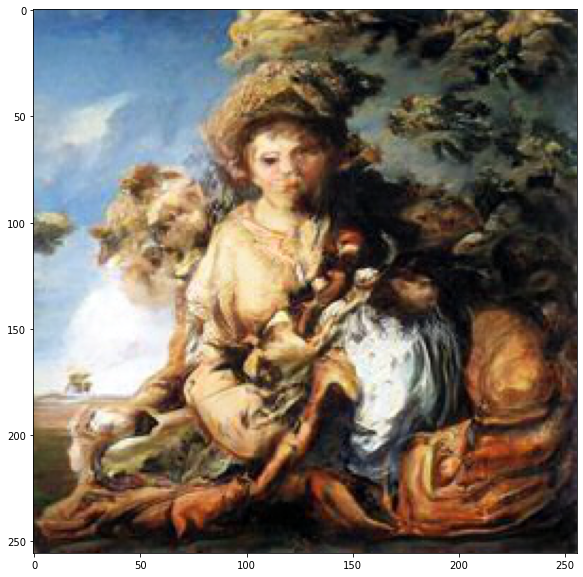

In [107]:
#----------------------------------------------------------------------------
from PIL import Image
import matplotlib.pyplot as plt

emotions = 'awe' # Change this to any emotion from this list: amusement, anger, awe, contentment, disgust, excitement, fear, sadness
trunc = 0.8 # Change 0.8 to be any truncation you'd like.

generate_images(emostylegan_model, [seed], trunc, outdir, emotions_dict[emotions], emotions) # pylint: disable=no-value-for-parameter
fig, ax = plt.subplots(nrows=1, ncols=1, figsize =(10, 10))
ax.imshow(Image.open(os.path.join(outdir, f'seed{str(seed).zfill(4)}_{emotions}.png')))
#----------------------------------------------------------------------------